### Compare reweighting techniques


The idea behind this notebook is to compare two reweighting techniques. One can reweight one distribution $p_0(x)$ to look like another distribution $p_1(x)$ by calculating a weight defined as $r=p_1(x)/p_0(x)$ and apply this weight to $p_0(x)$. 

The reweighting technique (that learns "CARL weights") is based on [Approximating Likelihood Ratios with Calibrated Discriminative Classifiers](http://inspirehep.net/record/1377273), which can take into account the full space instead of just two dimensions. In this notebook V+jets samples generated with Madgraph5 (original) and Sherpa (target) are compared, and the CARL weights are derived to reweight Madgraph5 to look like Sherpa.  

The performance of the weights, i.e. how well the reweighted original distribution matches the target distribution, is assessed by training a discriminator to differentiate the original distribution with weights applied from a target distribution.  

Work in progress by Leonora Vesterbacka. This notebook is based on the work by Kyle Cranmer, Juan Pavez, Gilles Louppe, March 2016. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import theano
from scipy.stats import chi2
from itertools import product
import root_numpy
import pandas as pd
import uproot
np.random.seed(314)

Welcome to JupyROOT 6.18/00


In [2]:
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier

# other classifiers from scikit-learn that you could also use
from sklearn.ensemble import ExtraTreesRegressor

# for calibration
from sklearn.model_selection import StratifiedShuffleSplit
from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV

In [3]:
#the example has much more real data than monte carlo
#this leads to unbalanced dataset
#some techniques deal with that better than others
data_to_use = ["all","max balanced"][1]

#if you use all the data the classifier score can be very peaked
#some classifiers can use weights (eg. the ExtraTreesRegressor)
#and that will make the distribution less peaked.
clf_type = ["mlp","trees","trees with weights"][0]

# the histogram and kde calibration don't work very well
#with very peaked output score distributions,
#but the isotonic approach does
calibration_type = ["isotonic", "kde", "histogram"][2]

#do either training using all phase space by defining do = "varAll", or just two variables by defining do = "var2"
do = ["two", "all"][1]
normalize = False

In [4]:
if do == "two":
    binning = [range(0, 2400, 200), range(0, 15, 1)]
    variables = ['VpT','Njets']
    weights = ['normweight']
if do == "all":
    etaV = [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    etaJ = [-2.8,-2.4,-2,-1.6,-1.2,-0.8,-0.4,0,0.4,0.8,1.2,1.6,2,2.4,2.8]
    variables = ['VpT','Njets','j1pT', 'j2pT', 'HT','ptmiss', 'l1pT','Veta','j1eta','j2eta']
    vlabels = ['V $\mathrm{p_{T}}$ [GeV]','Number of jets','Leading jet $\mathrm{p_{T}}$ [GeV]','Subleading jet $\mathrm{p_{T}}$ [GeV]', '$\mathrm{H_{T}}$ [GeV]','$\mathrm{p_{T}^{miss}}$ [GeV]', 'Leading lepton $\mathrm{p_{T}}$ [GeV]','V $\eta$','Leading jet $\eta$','Subleading jet $\eta$']
    binning = [range(0, 2400, 100), range(0, 15, 1), range(0, 2700, 100),range(0, 2700, 100),range(0, 4000, 200),range(0, 600, 50),range(0, 1500, 50), etaV, etaJ, etaJ]
    weights = ['normweight']
    #truthWeight is the generator weight
#get original and target samples, madgraph:original, sherpa:target
original  = root_numpy.root2array('/eos/user/m/mvesterb/data/madgraph/Nominal.root', branches=variables)
target    = root_numpy.root2array('/eos/user/m/mvesterb/data/sherpa/Nominal.root', branches=variables)
originalW = root_numpy.root2array('/eos/user/m/mvesterb/data/madgraph/Nominal.root', branches=weights)
targetW   = root_numpy.root2array('/eos/user/m/mvesterb/data/sherpa/Nominal.root', branches=weights)
#create dataframes to do the training on, and also get the sample weights in separate dataframes for resampling
oDF   = pd.DataFrame(original,columns=variables)
tDF   = pd.DataFrame(target,columns=variables)
oWDF  = pd.DataFrame(originalW,columns=weights)
tWDF  = pd.DataFrame(targetW,columns=weights)
print("original",oDF.shape)
print("target",tDF.shape)

('original', (716742, 10))
('target', (291260, 10))


A discriminator is trained to differentiate the original and the target distributions from each other, as well as differentiating the target distribution from the original distributions with the learned carl applied. Well learned weights would make the target and reweighted distributions very similar and indistinguishable for the discriminator. 

In [5]:
#if normalize, resample according to normalization weight
if normalize == True:
    pO    = (oWDF.normweight)/np.sum(oWDF.normweight.astype(np.float))
    pT    = (tWDF.normweight)/np.sum(tWDF.normweight.astype(np.float))
    iO    = np.random.choice(np.arange(len(oDF)),size=len(oDF),p=pO)
    iT    = np.random.choice(np.arange(len(tDF)),size=len(tDF),p=pT)
    o     = oDF.iloc[iO] #original
    t     = tDF.iloc[iT] #target
else:
    o = oDF
    t = tDF

In [6]:
#to randomize training and test data
n_target = o.values.shape[0]
randomized_original = o.values[np.random.choice(range(o.values.shape[0]),
                                 2*n_target,replace=True)]

X0_all = randomized_original[:n_target,:]
X0_test = randomized_original[n_target:,:]

#these are always the same training and testing data
#X0_all = o.values[:n_target,:]
#X0_test = o.values[-n_target:,:]

X1_all = t.values
print(o.values.shape)
print(X0_all.shape)
print(X0_test.shape)
print(X1_all.shape)

(716742, 10)
(716742, 10)
(716742, 10)
(291260, 10)


In [7]:
#make training data from all samples
num1 = X0_all.shape[0]
num2 = X1_all.shape[0]
X_all = np.vstack((X0_all,X1_all))
y_all = np.ones(num1 + num2, dtype=np.int)
y_all[num1:] = 0

#weight X0 or X1 so weighted samples are balanced
training_weights=np.ones(num1+num2)
#if num1>num2 apply weight < 1 to the num1 samples
training_weights[:num1] = np.minimum(1.,1.*num2/num1)
#vice versa
training_weights[num1:] = np.minimum(1.,1.*num1/num2)

#randomly sample X0 to have the same number of entries as X1
# assuming X0 is bigger here
X0_s = X0_all[np.random.choice(range(X0_all.shape[0]),num1,replace=True)]
X_s = np.vstack((X0_s, X1_all))
y_s = np.ones(num1 + num2, dtype=np.int)
y_s[num1:] = 0

X1_x = X1_all[np.random.choice(range(X1_all.shape[0]),num1,replace=True)]
X_x = np.vstack((X0_all, X1_x))
y_x = np.ones(num1 + num1, dtype=np.int)
y_x[num1:] = 0
#now use the flags to decide which of the datasets to use
X, X0, X1, y = None, None, None, None
if data_to_use == "all":
    X, X0, X1, y = X_all, X0_all, X1_all, y_all
elif data_to_use == "max balanced":
    X, X0, X1, y = X_s, X0_s, X1_all, y_s
else:    
    print("error")
    
print(X0.shape)
print(X1.shape)
print(y.shape)
print(X.shape)

(716742, 10)
(291260, 10)
(1008002,)
(1008002, 10)


### The unweighted 1-d distributions

Define a function that plots the original and target distributions

Test that the resampled and reweighted distributions give the same result

In [8]:
hist_settings0 = {'alpha': 0.3}
hist_settings1 = {'histtype':'step', 'color':'black', 'linewidth':1, 'linestyle':'--'}

def draw_distributions(weights=np.ones(X0[:,0].size)):
    plt.figure(figsize=(20, 12))
    columns = range(len(variables))
    for id, column in enumerate(columns, 1):
        plt.subplot(3,4, id)
        plt.yscale('log')
        plt.hist(X0[:,column], bins = binning[id-1],weights=weights, label = 'Madgraph', **hist_settings0)
        plt.hist(X1[:,column], bins = binning[id-1],label = 'Sherpa', **hist_settings1)
        plt.xlabel('%s'%(vlabels[id-1])) 
        plt.legend(frameon=False)
        axes = plt.gca()
        axes.set_ylim([1,10000000])

def draw_distributionsCARL(weights=np.ones(X0[:,0].size)):
    plt.figure(figsize=(20, 12))
    columns = range(len(variables))
    for id, column in enumerate(columns, 1):
        plt.subplot(3,4, id)
        plt.yscale('log')
        plt.hist(X0[:,column], bins = binning[id-1], label = 'Madgraph', **hist_settings0)
        plt.hist(X0[:,column], bins = binning[id-1], weights=weights, label = 'Madgraph * CARL', **hist_settings0)
        plt.hist(X1[:,column], bins = binning[id-1], label = 'Sherpa',**hist_settings1)
        plt.xlabel('%s'%(vlabels[id-1]))   
        plt.legend(frameon=False)
        axes = plt.gca()
        axes.set_ylim([1,10000000])
        
def draw_distributionsTEST(weights=np.ones(X0_test[:,0].size)):
    plt.figure(figsize=(20, 12))
    columns = range(len(variables))
    for id, column in enumerate(columns, 1):
        plt.subplot(3,4, id)
        plt.yscale('log')
        plt.hist(X0_test[:,column], bins = binning[id-1], label = 'Madgraph', **hist_settings0)
        plt.hist(X0_test[:,column], bins = binning[id-1], weights=weights, label = 'Madgraph * CARL', **hist_settings0)
        plt.hist(X1[:,column], bins = binning[id-1], label = 'Sherpa',**hist_settings1)
        plt.xlabel('%s'%(vlabels[id-1]))   
        plt.legend(frameon=False)
        axes = plt.gca()
        axes.set_ylim([1,10000000])    

def draw_distributionsOG(weights=np.ones(o.size)):
    plt.figure(figsize=(5, 4))
    binning = range(0, 15, 1)
    #plt.subplot(3,4, id)
    plt.yscale('log')
    plt.hist(o.Njets, bins = binning, label = 'Madgraph', **hist_settings0)
    plt.hist(o.Njets, bins = binning, weights=weights, label = 'Madgraph * CARL', **hist_settings0)
    plt.hist(t.Njets, bins = binning, label = 'Sherpa',**hist_settings1)
    plt.xlabel('Njets')   
    plt.legend(frameon=False)
    axes = plt.gca()
    axes.set_ylim([1,10000000])            

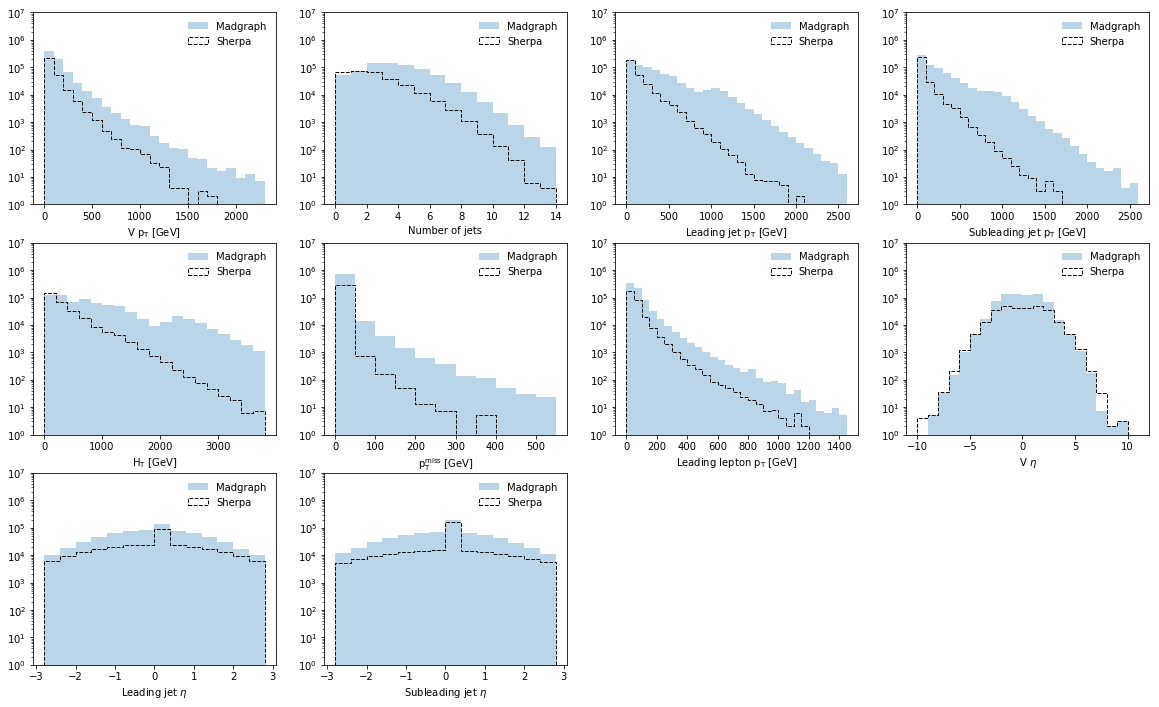

In [9]:
draw_distributions()

### Learning the carl weights

This approach is based on [Approximating Likelihood Ratios with Calibrated Discriminative Classifiers](http://inspirehep.net/record/1377273). 

We will use the [carl](https://github.com/diana-hep/carl) package to approximate the likelihood ratio by first training a neural network classifier and then calibrating the output to be the likelihood ratio. Any other type of classifier could also be used.

In [10]:
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# configure the classifier and train it
classifier = None
if clf_type == "mlp":
    classifier = make_pipeline(StandardScaler(),
                   as_classifier(MLPRegressor(tol=1e-05, activation="logistic", 
                   hidden_layer_sizes=(10, 10), learning_rate_init=1e-07, 
                   learning_rate="constant", solver="lbfgs", random_state=1, 
                   max_iter=75)))
    classifier.fit(X,y) 
elif clf_type =="trees":
    classifier = make_pipeline(StandardScaler(),
                       as_classifier(ExtraTreesRegressor(n_estimators=250, max_leaf_nodes=15)))
    classifier.fit(X,y) # unbalanced data
    
elif clf_type == "trees with weights":
    regressor = ExtraTreesRegressor(n_estimators=250, max_leaf_nodes=15)
    regressor.fit(X,y, sample_weight=training_weights) # unbalanced, weighted data
    classifier = as_classifier(ExtraTreesRegressor(n_estimators=250, max_leaf_nodes=15))
    classifier.regressor_ = regressor

elif clf_type == "trees with weights" and data_to_use == "max balanced":
    print("not implemented, use all data right now")

else:
    print("configuration error")

ratio = ClassifierRatio(CalibratedClassifierCV(
        base_estimator=classifier, 
        cv="prefit",  # keep the pre-trained classifier
        method=calibration_type, bins=100))
# now train calibrate the ratio 
ratio.fit(X=X, y=y, n_samples=y.size)

ClassifierRatio(base_estimator=CalibratedClassifierCV(base_estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('wrapper', Wrapper(base_estimator=MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999...    bins=100, cv='prefit', interpolation=None, method='histogram',
            variable_width=False),
        random_state=None)

### Check the result of CARL weights on 1D distributions

check weights derived on training set, test set and on original dataframes

1. on training set:

carl/distributions/histogram.py:61: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.histogram_[all_indices]


('carl_weights', array([0.00478951, 0.12930523, 0.02109158, ..., 0.09440618, 0.09440618,
       0.94775475]))


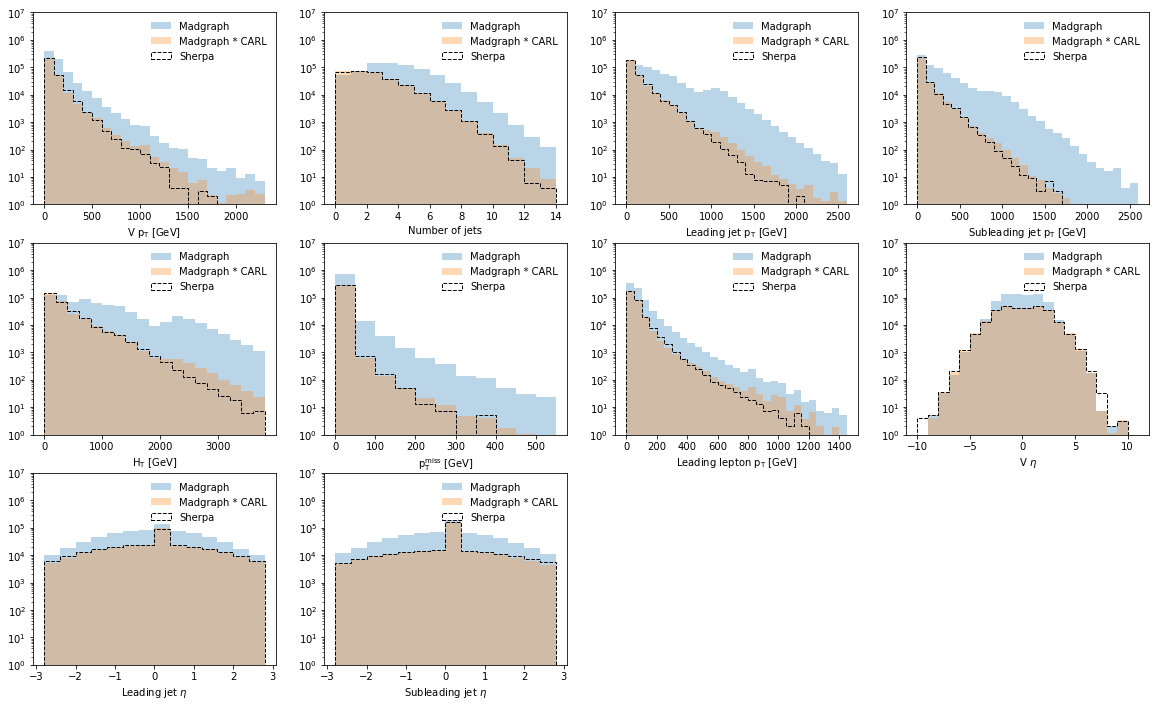

In [11]:
carl_weights = ratio.predict(X0)
carl_weights[carl_weights == np.inf] = 1
carl_weightsScaled = carl_weights / carl_weights.sum() * len(X1)
print("carl_weights", carl_weightsScaled)
draw_distributionsCARL(carl_weightsScaled)

2. on test set:

('carl_weights', array([0.6996838 , 1.67307907, 0.0533334 , ..., 0.03415977, 0.146216  ,
       0.16607411]))


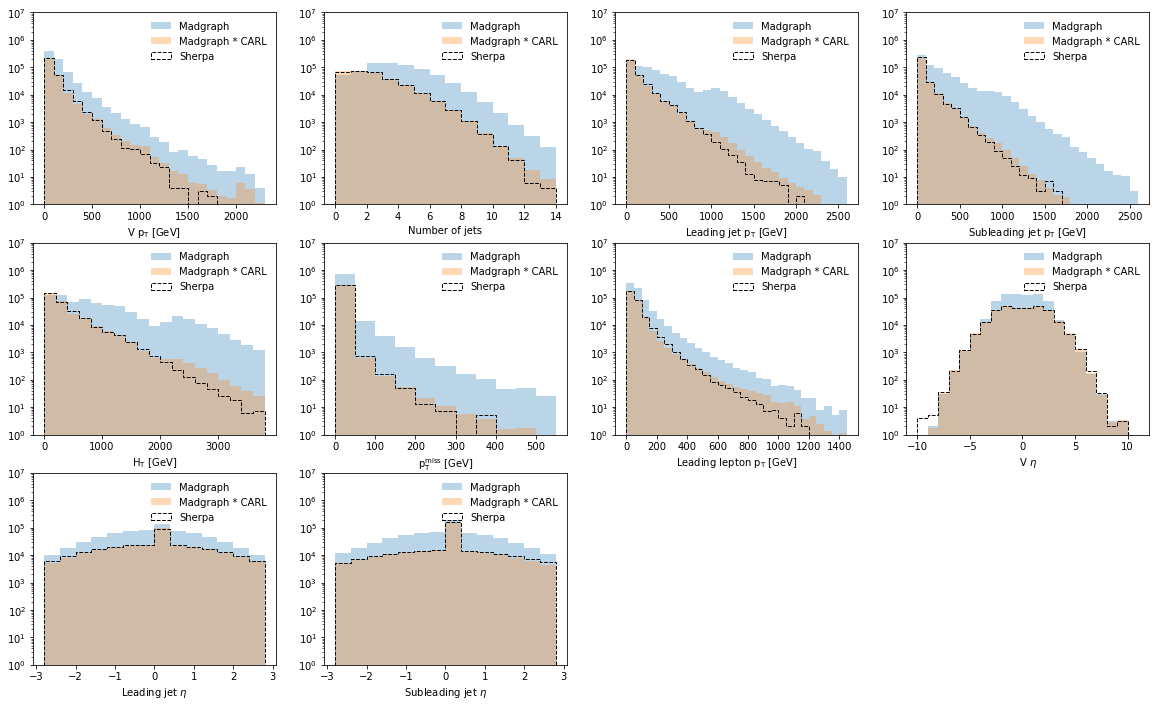

In [12]:
carl_weights = ratio.predict(X0_test)
carl_weights[carl_weights == np.inf] = 1
carl_weightsScaled = carl_weights / carl_weights.sum() * len(X1)
print("carl_weights", carl_weightsScaled)
draw_distributionsTEST(carl_weightsScaled)

3. on test original dataframes:

/cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int32, float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


('carl_weights', array([0.83278401, 0.54186652, 0.54905402, ..., 0.09416805, 0.08607364,
       0.08770858]))


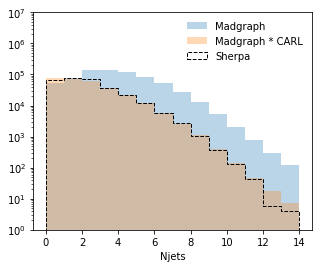

In [13]:
carl_weights = ratio.predict(o)
carl_weights[carl_weights == np.inf] = 1
carl_weightsScaled = carl_weights / carl_weights.sum() * len(t)
print("carl_weights", carl_weightsScaled)
draw_distributionsOG(carl_weightsScaled)

## ROC curves for quantitative assessment of performance

We want to quantify how well the reweighted distribution matches target distribution, but this is challenging in high dimensions. So we will train a new classifier, call it the *discriminator*, that will try to predict if an event is from the reweighted distribution or the real target. If it can tell the difference, then we haven't done a good job in reweighting. If we have done a good job in reweighting, then we don't expect that it will be able to tell the difference and the ROC curve should just be a diagonal line with Area Under the Curve (AUC) of 0.5. 

*Note*: This is similar to the use of the discriminator in the paper [Generative Adversarial Nets](http://arxiv.org/abs/1406.2661).

We consider two ways of doing this
   * use a discriminator trained with data *resampled proportional to weights*. The advantage of this approach is that the discriminator only deals with unweighted events.
   * use a discriminator that can be *trained with weights*. 

The two approaches give similar results.

In [14]:
# generate some new data to make the ROC curve.
# if we used the same data we might be fooled by overfitting
X0_roc = X0_test
X1_roc = X1

# Weighted with approximate likelihood ratios from carl
carl_weights_roc = ratio.predict(X0_roc,log=False)
carl_weights_roc[np.isinf(carl_weights_roc)] = 0.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc

def weight_data(x0,x1,weights, max_weight=10000.):
    x1_len = x1.shape[0]
    x0_len = x0.shape[0]
    weights[weights>max_weight]=max_weight

    weights = weights / weights.sum()
    weighted_data = np.random.choice(range(x0_len), x0_len, p = weights)
    w_x0 = x0.copy()[weighted_data]
    y = np.zeros(x1_len + x0_len)
    x_all = np.vstack((w_x0,x1))
    y_all = np.zeros(x1_len +x0_len)
    y_all[x0_len:] = 1
    return (x_all,y_all)

def resampled_discriminator_and_roc(original, target, weights):   

    (data, labels) = weight_data(original,target,weights)
    W = np.concatenate([weights / weights.sum() * len(target), [1] * len(target)])
    Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.51, test_size=0.49)    
    
    discriminator = MLPRegressor(tol=1e-05, activation="logistic", 
               hidden_layer_sizes=(10, 10), learning_rate_init=1e-07, 
               learning_rate="constant", solver="lbfgs", random_state=1, 
               max_iter=75)

    discriminator.fit(Xtr,Ytr)

    predicted = discriminator.predict(Xts)

    fpr, tpr, _  = roc_curve(Yts,predicted.ravel())
    roc_auc = auc(fpr, tpr)
    return fpr,tpr,roc_auc


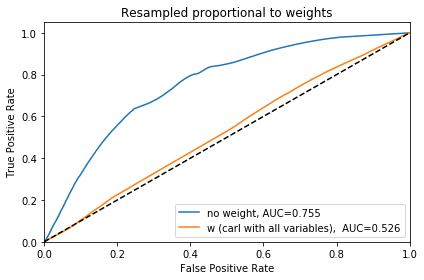

In [16]:
fpr_t,tpr_t,roc_auc_t = resampled_discriminator_and_roc(X0_roc, X1_roc, np.ones(X0_roc.shape[0]))
plt.plot(fpr_t, tpr_t, label=r"no weight, AUC=%.3f" % roc_auc_t)
#applying weights that are just 1, i.e. no weights
fpr_tC,tpr_tC,roc_auc_tC = resampled_discriminator_and_roc(X0_roc, X1_roc, carl_weights_roc)
plt.plot(fpr_tC, tpr_tC, label=r"w (carl with %s variables),  AUC=%.3f" %(do, roc_auc_tC))
#applying carl weights

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Resampled proportional to weights')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('plots/roc_resampled_%sVariables.png'%(do))

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

def weighted_discriminator_and_roc(original, target, weights):
    data = np.concatenate([original, target])
    labels = np.array([0] * len(original) + [1] * len(target))

    W = np.concatenate([weights / weights.sum() * len(target), [1] * len(target)])
    Xtr, Xts, Ytr, Yts, Wtr, Wts = train_test_split(data, labels, W, random_state=42, train_size=0.51, test_size = 0.49)
    clf = GradientBoostingClassifier(subsample=0.3, n_estimators=30).fit(Xtr, Ytr, sample_weight=Wtr)
    
    fpr, tpr, _  = roc_curve(Yts, clf.predict_proba(Xts)[:, 1], sample_weight=Wts)
    #roc_auc = auc(Yts, clf.predict_proba(Xts)[:, 1], sample_weight=Wts)
    roc_auc = auc(fpr, tpr,reorder=True)
    return fpr, tpr, roc_auc

In [ ]:
fpr_t,tpr_t,roc_auc_t = weighted_discriminator_and_roc(X0_roc, X1_roc, np.ones(X0_roc.shape[0]))
plt.plot(fpr_t, tpr_t, label=r"$w_{truth}$, AUC=%.3f" % roc_auc_t)

fpr_t,tpr_t,roc_auc_t = weighted_discriminator_and_roc(X0_roc, X1_roc, carl_weights_roc)
plt.plot(fpr_t, tpr_t, label=r"$w_{learn}$ (CARL), AUC=%.3f" % roc_auc_t)


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Discriminator trained with weights')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('plots/roc_weighted_%sVariables.png'%(do))

/cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
